# 03 R2F vs MDI for correlated Features

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sys
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle as pkl
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

sys.path.append('../..')
from nonlinear_significance.scripts.TreeTester import TreeTester

from simulations_util import *

In [33]:
def run_sim(n, d, s, rho_grid, reg_func, runs=10, params=None, normalize=True, max_components="median"):
    all_results = {}
    all_aucs = {}
    signal_features = np.concatenate([np.ones(s), np.zeros(d-s)])
    for rho in tqdm(rho_grid):
        Sigma = np.eye(d)
        Sigma[0, s] = rho
        Sigma[s, 0] = rho
        score_results = defaultdict(list)
        score_aucs = defaultdict(list)
        for r in range(runs):
            # fit model
            X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
            y = reg_func(X, **params)
            rf_model = RandomForestRegressor(max_features=0.33)
            rf_model.fit(X, y)
            # mdi
            score_results["mdi"].append(rf_model.feature_importances_ / np.sum(rf_model.feature_importances_))
            score_aucs["mdi"].append(roc_auc_score(signal_features, rf_model.feature_importances_))
            # r2f
            tree_tester = TreeTester(rf_model, max_components)
            r2f_result = tree_tester.get_r_squared_sig_threshold(X, y)
            if normalize:
                r2f_result /= np.sum(r2f_result)
            score_results["r2f"].append(r2f_result)
            score_aucs["r2f"].append(roc_auc_score(signal_features, r2f_result))
            # r2f original
            _, r2f_orig_result = tree_tester.get_feature_significance_and_ranking(X, y)
            if normalize:
                r2f_orig_result /= np.sum(r2f_orig_result)
            score_results["r2f_orig"].append(r2f_orig_result)
            score_aucs["r2f_orig"].append(roc_auc_score(signal_features, r2f_orig_result))
        all_results[rho] = score_results
        all_aucs[rho] = score_aucs
    return all_results, all_aucs


def process_results(score_results, rho_grid):
    score_means = defaultdict(list)
    score_stds = defaultdict(list)
    for rho in rho_grid:
        for key in ["mdi", "r2f", "r2f_orig"]:
            score_means[key].append(np.array(score_results[rho][key]).mean(axis=0))
            score_stds[key].append(np.array(score_results[rho][key]).std(axis=0))
    for key in ["mdi", "r2f", "r2f_orig"]:
        score_means[key] = pd.DataFrame(score_means[key])
        score_stds[key] = pd.DataFrame(score_stds[key])

    return score_means, score_stds


def get_aucs(score_results, rho_grid, s):
    score_aucs = defaultdict(list)
    signal_features = np.concatenate([np.ones(s), np.zeros(d-s)])
    for rho in rho_grid:
        aucs_for_rho = defaultdict(list)
        for key in ["mdi", "r2f", "r2f_orig"]:
            for run_result in score_results[rho][key]:
                auc = restricted_roc_auc_score(signal_features, run_result, ignored_indices=[s])
                aucs_for_rho[key].append(auc)
        score_aucs[rho] = aucs_for_rho

    return score_aucs


def process_aucs(score_aucs, rho_grid):
    score_auc_means = defaultdict(list)
    score_auc_stds = defaultdict(list)
    for rho in rho_grid:
        for key in ["mdi", "r2f", "r2f_orig"]:
            score_auc_means[key].append(np.mean(score_aucs[rho][key]))
            score_auc_stds[key].append(np.std(score_aucs[rho][key]))
    for key in ["mdi", "r2f", "r2f_orig"]:
        score_means[key] = pd.DataFrame(score_means[key])
        score_stds[key] = pd.DataFrame(score_stds[key])

    return score_auc_means, score_auc_stds


def plot_results(score_means, score_stds, s, errbars=False,
                 save=False, experiment_name=None, ylim=None):
    for score in ["mdi", "r2f", "r2f_orig"]:
        plt.figure(figsize=(10, 5))
        if errbars:
            stds = score_stds[score]
        else:
            stds = pd.DataFrame(np.zeros_like(score_stds[score]))
        plt.errorbar(range(len(rho_grid)), score_means[score].iloc[:,0], yerr=stds.iloc[:,0], label=0)
        for i in range(1, s):
            plt.errorbar(range(len(rho_grid)), score_means[score].iloc[:,i], yerr=stds.iloc[:,i], label=i, color="orange")
        plt.errorbar(range(len(rho_grid)), score_means[score].iloc[:,s], yerr=stds.iloc[:,s], label=s, color="red")
        for i in range(s+1, d):
            plt.errorbar(range(len(rho_grid)), score_means[score].iloc[:,i], yerr=stds.iloc[:,i], label=i, color="gray", alpha=0.2)
        plt.legend()
        plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
        plt.xlabel("rho")
        plt.title(score)
        if ylim is not None:
            plt.ylim(ylim)
        if save:
            plt.savefig(os.path.join("plots", f"{experiment_name}_{score}.png"))
        plt.show()


def plot_aucs(auc_means, auc_stds, save=False, experiment_name=None, ylim=None, r2f_only=True):
    plt.figure(figsize=(10, 5))
    color_dict = {"mdi": "green",
                  "r2f": "black",
                  "r2f_orig": "grey"}
    for score in ["mdi", "r2f"]:
        plt.errorbar(range(len(rho_grid)), auc_means[score], yerr=auc_stds[score], label=score, color=color_dict[score])
    if not r2f_only:
        plt.errorbar(range(len(rho_grid)), auc_means["r2f_orig"], yerr=auc_stds["r2f_orig"], label="r2f_orig")
    plt.legend()
    plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
    plt.xlabel("rho")
    plt.title("ROAUC")
    if ylim is not None:
        plt.ylim(ylim)
    if save:
        plt.savefig(os.path.join("plots", f"{experiment_name}_auc.png"))
        plt.show()


def restricted_roc_auc_score(y_true, y_score, ignored_indices=[]):
    n_examples = len(y_true)
    mask = [i for i in range(n_examples) if i not in ignored_indices]
    restricted_auc = roc_auc_score(np.array(y_true)[mask], np.array(y_score)[mask])
    return restricted_auc

## 1. Correlated features: MDI vs R2F

### 1.1 Linear model

Set up: Linear model on 10 variables, with $\beta_i=1$ for $i=0,1,2$. All features are uncorrelated, except for $X_0$ and $X_3$, which have correlation $\rho$.

In [10]:
%%capture

n = 200
d = 10
s = 3
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 5
runs = 10
params = {"s": s,
          "sigma": sigma,
          "beta": beta}

lin_model_results = {}
#lin_model_results["scores"], lin_model_results["aucs"] = run_sim(n, d, s, rho_grid, linear_model, runs=10, params=params)

In [11]:
output_file = "results/lin_results.pkl"
# pkl.dump(lin_model_results, open(output_file, "wb"))
lin_model_results = pkl.load(open(output_file, "rb"))
score_means, score_stds = process_results(lin_model_results["scores"], rho_grid)
aucs = get_aucs(lin_model_results["scores"], rho_grid, s)
auc_means, auc_stds = process_aucs(aucs, rho_grid)

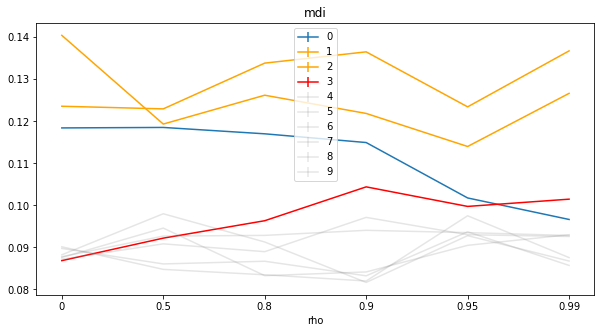

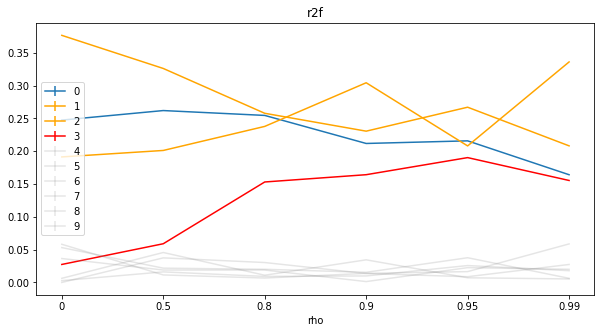

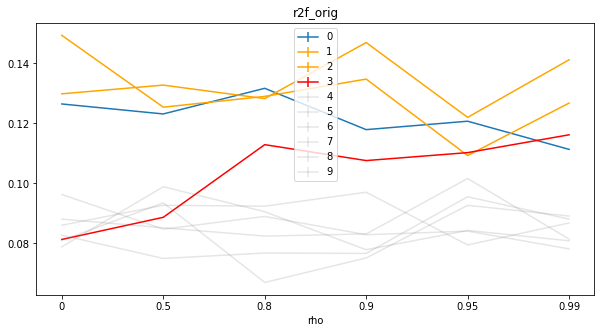

In [32]:
plot_results(score_means, score_stds, s, save=True, experiment_name="lin_corr", errbars=False)

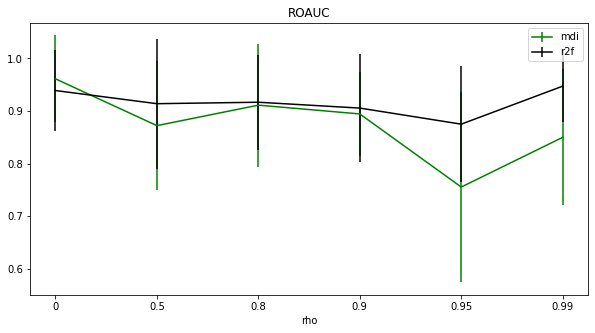

In [39]:
plot_aucs(auc_means, auc_stds, save=True, experiment_name="lin_corr")

### 1.2 LSS

Set up: LSS model on 10 variables, with $y = \mathbf{1}(X_0 > 0, X_1 > 0) + \mathbf{1}(X_2 > 0, X_3 > 0) + \epsilon$. All features are uncorrelated, except for $X_0$ and $X_4$, which have correlation $\rho$.

In [36]:
%%capture

n = 200
d = 10
s = 4
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 1.5
runs = 10
params = {"sigma": sigma,
          "beta": beta,
          "m": 2,
          "r": 2,
          "tau": 0}

lss_model_results = {}
#lss_model_results["scores"], lss_model_results["aucs"] = run_sim(n, d, s, rho_grid, lss_model, runs=10, params=params)

In [37]:
output_file = "results/lss_results.pkl"
#pkl.dump(lss_model_results, open(output_file, "wb"))
lss_model_results = pkl.load(open(output_file, "rb"))
lss_score_means, lss_score_stds = process_results(lss_model_results["scores"], rho_grid)
lss_aucs = get_aucs(lss_model_results["scores"], rho_grid, s)
lss_auc_means, lss_auc_stds = process_aucs(lss_aucs, rho_grid)

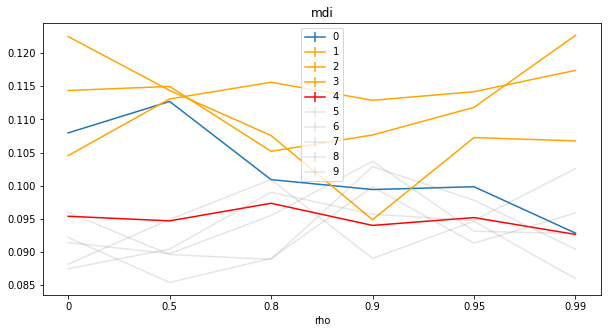

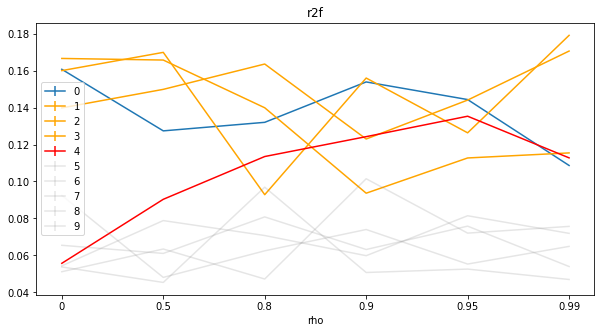

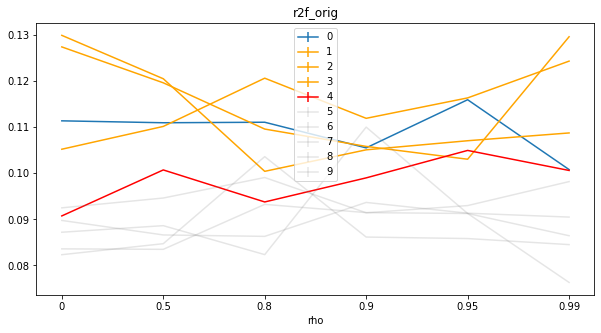

In [38]:
plot_results(lss_score_means, lss_score_stds, s, save=True, experiment_name="lss_corr")

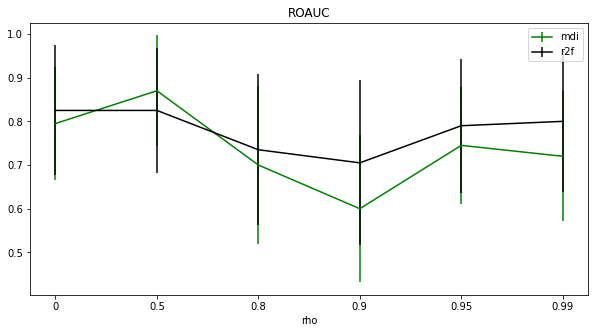

In [40]:
plot_aucs(lss_auc_means, lss_auc_stds, save=True, experiment_name="lss_corr", r2f_only=True)

### 1.3 Sum of squares model

Set up: Sum of squares model on 10 variables: $y = X_0^2 + X_1^2 + X_2^2$. All features are uncorrelated, except for $X_0$ and $X_3$, which have correlation $\rho$.

In [37]:
%%capture

n = 200
d = 10
s = 3
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 7
runs = 20
params = {"s": s,
          "sigma": sigma,
          "beta": beta}

ss_model_results = {}
ss_model_results["scores"], ss_model_results["aucs"] = run_sim(n, d, s, rho_grid, sum_of_squares, runs=10, params=params, max_components="median")

In [38]:
output_file = "results/ss_results.pkl"
pkl.dump(ss_model_results, open(output_file, "wb"))
#ss_model_results = pkl.load(open(output_file, "rb"))
ss_score_means, ss_score_stds = process_results(ss_model_results["scores"], rho_grid)
ss_aucs = get_aucs(ss_model_results["scores"], rho_grid, s)
ss_auc_means, ss_auc_stds = process_aucs(ss_aucs, rho_grid)

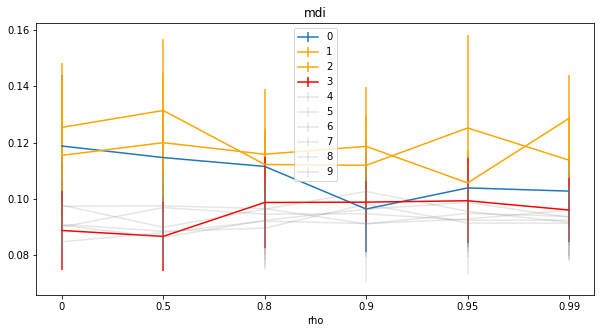

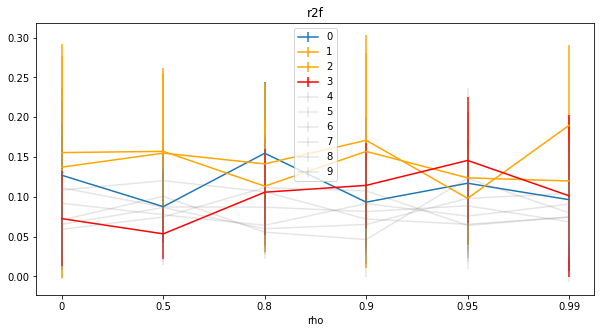

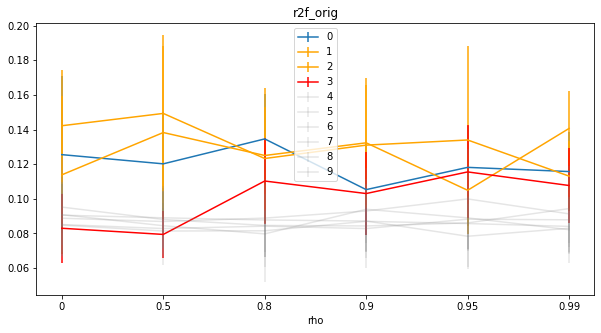

In [41]:
plot_results(ss_score_means, ss_score_stds, s, save=True, experiment_name="ss_corr")

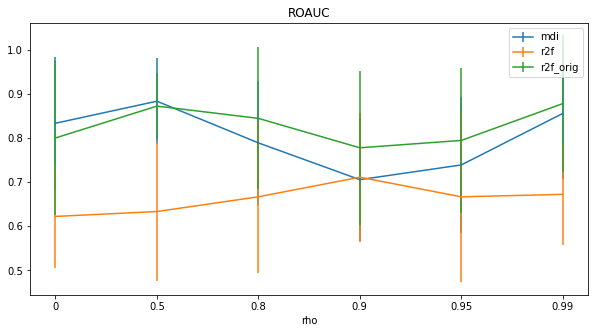

In [42]:
plot_aucs(ss_auc_means, ss_auc_stds, save=True, experiment_name="ss_corr", r2f_only=False)

## 2. Old

In [125]:
%%capture

n = 200
d = 10
s = 3
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 5
runs = 10

mdi_means = []
mdi_stds = []
r2f_means = []
r2f_stds = []
r2f_orig_means = []
r2f_orig_stds = []
for rho in tqdm(rho_grid):
    Sigma = np.eye(d)
    Sigma[0, s] = rho
    Sigma[s, 0] = rho
    mdi_results = []
    r2f_results = []
    r2f_orig_results = []
    for r in range(runs):
        X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
        y = linear_model(X, sigma, s, beta)
        rf_model = RandomForestRegressor(max_features=0.33)
        rf_model.fit(X, y)
        mdi_results.append(rf_model.feature_importances_ / np.sum(rf_model.feature_importances_))
        tree_tester = TreeTester(rf_model)
        r2f_results.append(tree_tester.get_r_squared_sig_threshold(X, y, add_linear=True))
        _, r2f_orig_result = tree_tester.get_feature_significance_and_ranking(X, y)
        r2f_orig_results.append(r2f_orig_result)
    mdi_results = np.array(mdi_results)
    r2f_results = np.array(r2f_results)
    r2f_orig_results = np.array(r2f_orig_results)
    mdi_means.append(np.mean(mdi_results, axis=0))
    mdi_stds.append(np.std(mdi_results, axis=0))
    r2f_means.append(np.mean(r2f_results, axis=0))
    r2f_stds.append(np.std(r2f_results, axis=0))
    r2f_orig_means.append(np.mean(r2f_orig_results, axis=0))
    r2f_orig_stds.append(np.std(r2f_orig_results, axis=0))
mdi_means = pd.DataFrame(mdi_means)
mdi_stds = pd.DataFrame(mdi_stds)
r2f_means = pd.DataFrame(r2f_means)
r2f_means /= r2f_means.sum(axis=1)[5]
r2f_stds = pd.DataFrame(r2f_stds)
r2f_stds /= r2f_means.sum(axis=1)[5]
r2f_orig_means = pd.DataFrame(r2f_orig_means)
r2f_orig_means /= r2f_orig_means.sum(axis=1)[5]
r2f_orig_stds = pd.DataFrame(r2f_orig_stds)
r2f_orig_stds /= r2f_orig_means.sum(axis=1)[5]

In [95]:
lin_results = [mdi_means, mdi_stds, r2f_means, r2f_stds, r2f_orig_means, r2f_orig_stds]
output_file = "results/lin_results.pkl"
pkl.dump(lin_results, open(output_file, "wb"))

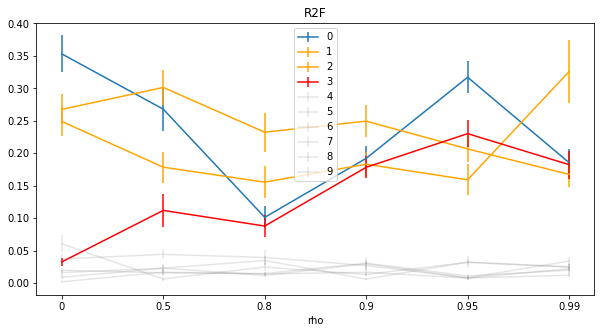

In [126]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,0], yerr=r2f_stds[0], label=0)
for i in range(1, s):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i, color="orange")
plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,s], yerr=r2f_stds[s], label=s, color="red")
for i in range(s+1, d):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i, color="gray", alpha=0.2)
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("R2F")
#plt.savefig("plots/lin_corr_R2F.png")
plt.show()

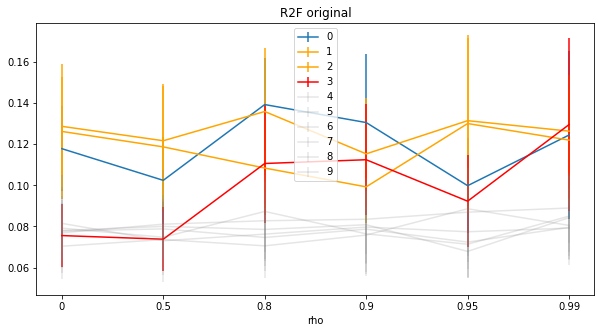

In [97]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(rho_grid)), r2f_orig_means.iloc[:,0], yerr=r2f_orig_stds[0], label=0)
for i in range(1, s):
    plt.errorbar(range(len(rho_grid)), r2f_orig_means.iloc[:,i], yerr=r2f_orig_stds[i], label=i, color="orange")
plt.errorbar(range(len(rho_grid)), r2f_orig_means.iloc[:,s], yerr=r2f_orig_stds[s], label=s, color="red")
for i in range(s+1, d):
    plt.errorbar(range(len(rho_grid)), r2f_orig_means.iloc[:,i], yerr=r2f_orig_stds[i], label=i, color="gray", alpha=0.2)
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("R2F original")
plt.show()

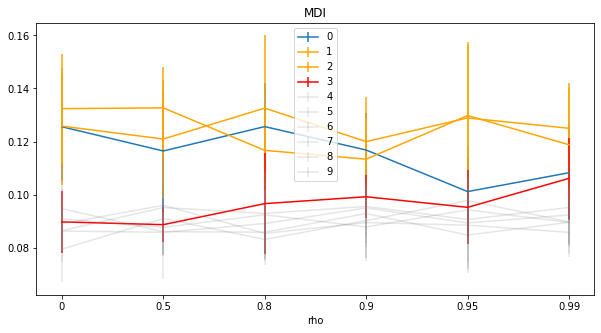

In [98]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,0], yerr=mdi_stds[0], label=0)
for i in range(1, s):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i], yerr=mdi_stds[i], label=i, color="orange")
plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,s], yerr=mdi_stds[s], label=s, color="red")
for i in range(s+1, d):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i], yerr=mdi_stds[i], label=i, color="gray", alpha=0.2)
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("MDI")
plt.show()

Above sim: Feature 0 and 3 are correlated, true model is linear on features 0-2.

### 1.2 LSS

Set up: LSS model on 10 variables, with $y = \mathbf{1}(X_0 > 0, X_1 > 0) + \mathbf{1}(X_2 > 0, X_3 > 0) + \epsilon$. All features are uncorrelated, except for $X_0$ and $X_4$, which have correlation $\rho$.

In [60]:
%%capture

n = 200
d = 10
s = 4
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 1.5
runs = 10

mdi_means = []
mdi_stds = []
r2f_means = []
r2f_stds = []
# r2f_orig_means = []
# r2f_orig_stds = []
for rho in tqdm(rho_grid):
    Sigma = np.eye(d)
    Sigma[0, s] = rho
    Sigma[s, 0] = rho
    mdi_results = []
    r2f_results = []
    # r2f_orig_results = []
    for r in range(runs):
        X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
        y = lss_model(X, sigma, 2, 2, 0, beta)
        rf_model = RandomForestRegressor(max_features=0.33)
        rf_model.fit(X, y)
        mdi_results.append(rf_model.feature_importances_ / np.sum(rf_model.feature_importances_))
        tree_tester = TreeTester(rf_model)
        r2f_results.append(tree_tester.get_r_squared_sig_threshold(X, y, add_linear=True, first_ns=False))
        # _, r2f_orig_result = tree_tester.get_feature_significance_and_ranking(X, y)
        # r2f_orig_results.append(r2f_orig_result)
    mdi_results = np.array(mdi_results)
    r2f_results = np.array(r2f_results)
    # r2f_orig_results = np.array(r2f_orig_results)
    mdi_means.append(np.mean(mdi_results, axis=0))
    mdi_stds.append(np.std(mdi_results, axis=0))
    r2f_means.append(np.mean(r2f_results, axis=0))
    r2f_stds.append(np.std(r2f_results, axis=0))
    # r2f_orig_means.append(np.mean(r2f_orig_results, axis=0))
    # r2f_orig_stds.append(np.std(r2f_orig_results, axis=0))
mdi_means = pd.DataFrame(mdi_means)
mdi_stds = pd.DataFrame(mdi_stds)
r2f_means = pd.DataFrame(r2f_means)
r2f_stds = pd.DataFrame(r2f_stds)
# r2f_orig_means = pd.DataFrame(r2f_orig_means)
# r2f_orig_stds = pd.DataFrame(r2f_orig_stds)

In [80]:
LSS_results = [mdi_means, mdi_stds, r2f_means, r2f_stds]
output_file = "results/LSS_results.pkl"
pkl.dump(LSS_results, open(output_file, "wb"))

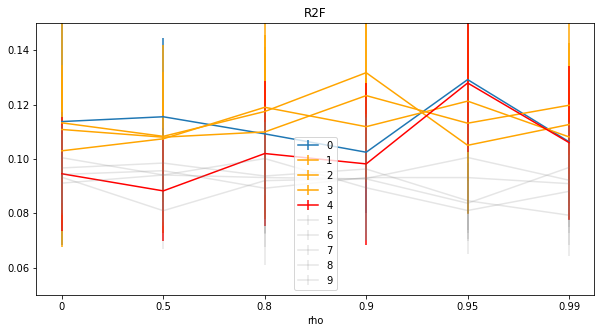

In [85]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,0] / r2f_means.sum(axis=1)[5], yerr=r2f_stds[0] / r2f_means.sum(axis=1)[5], label=0)
for i in range(1, s):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i] / r2f_means.sum(axis=1)[5], yerr=r2f_stds[i] / r2f_means.sum(axis=1)[5], label=i, color="orange")
plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,s] / r2f_means.sum(axis=1)[5], yerr=r2f_stds[s] / r2f_means.sum(axis=1)[5], label=s, color="red")
for i in range(s+1, d):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i] / r2f_means.sum(axis=1)[5], yerr=r2f_stds[i] / r2f_means.sum(axis=1)[5], label=i, color="gray", alpha=0.2)
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.ylim([0.05, 0.15])
plt.title("R2F")
plt.savefig("plots/LSS_corr_R2F.png")
plt.show()

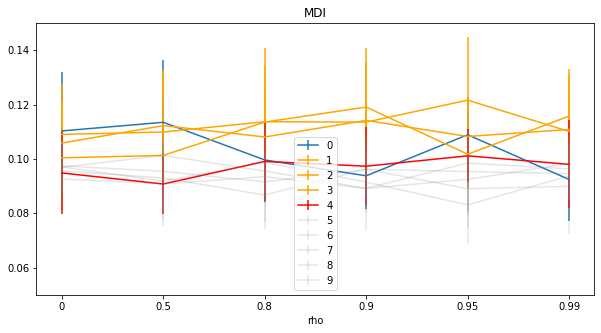

In [86]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,0] / mdi_means.sum(axis=1)[5], yerr=mdi_stds[0] / mdi_means.sum(axis=1)[5], label=0)
for i in range(1, s):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i] / mdi_means.sum(axis=1)[5], yerr=mdi_stds[i] / mdi_means.sum(axis=1)[5], label=i, color="orange")
plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,s] / mdi_means.sum(axis=1)[5], yerr=mdi_stds[s] / mdi_means.sum(axis=1)[5], label=s, color="red")
for i in range(s+1, d):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i] / mdi_means.sum(axis=1)[5], yerr=mdi_stds[i] / mdi_means.sum(axis=1)[5], label=i, color="gray", alpha=0.2)
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.ylim([0.05, 0.15])
plt.title("MDI")
plt.savefig("plots/LSS_corr_MDI.png")
plt.show()

### 1.3 Sum of squares model

Set up: Sum of squares model on 10 variables: $y = X_0^2 + X_1^2 + X_2^2$. All features are uncorrelated, except for $X_0$ and $X_3$, which have correlation $\rho$.

In [ ]:
%%capture

n = 200
d = 10
s = 3
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 5
runs = 10

mdi_means = []
mdi_stds = []
r2f_means = []
r2f_stds = []
r2f_orig_means = []
r2f_orig_stds = []
for rho in tqdm(rho_grid):
    Sigma = np.eye(d)
    Sigma[0, s] = rho
    Sigma[s, 0] = rho
    mdi_results = []
    r2f_results = []
    r2f_orig_results = []
    for r in range(runs):
        X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
        y = sum_of_squares(X, sigma, s, beta)
        rf_model = RandomForestRegressor(max_features=0.33)
        rf_model.fit(X, y)
        mdi_results.append(rf_model.feature_importances_ / np.sum(rf_model.feature_importances_))
        tree_tester = TreeTester(rf_model)
        r2f_results.append(tree_tester.get_r_squared_sig_threshold(X, y, add_linear=True))
        _, r2f_orig_result = tree_tester.get_feature_significance_and_ranking(X, y)
        r2f_orig_results.append(r2f_orig_result)
    mdi_results = np.array(mdi_results)
    r2f_results = np.array(r2f_results)
    r2f_orig_results = np.array(r2f_orig_results)
    mdi_means.append(np.mean(mdi_results, axis=0))
    mdi_stds.append(np.std(mdi_results, axis=0))
    r2f_means.append(np.mean(r2f_results, axis=0))
    r2f_stds.append(np.std(r2f_results, axis=0))
    r2f_orig_means.append(np.mean(r2f_orig_results, axis=0))
    r2f_orig_stds.append(np.std(r2f_orig_results, axis=0))
mdi_means = pd.DataFrame(mdi_means)
mdi_stds = pd.DataFrame(mdi_stds)
r2f_means = pd.DataFrame(r2f_means)
r2f_means /= r2f_means.sum(axis=1)[5]
r2f_stds = pd.DataFrame(r2f_stds)
r2f_stds /= r2f_means.sum(axis=1)[5]
r2f_orig_means = pd.DataFrame(r2f_orig_means)
r2f_orig_means /= r2f_orig_means.sum(axis=1)[5]
r2f_orig_stds = pd.DataFrame(r2f_orig_stds)
r2f_orig_stds /= r2f_orig_means.sum(axis=1)[5]

In [2]:
%%capture

n = 100
d = 10
s = 5
t = 5
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 0.1
runs = 10

mdi_means = []
mdi_stds = []
r2f_means = []
r2f_stds = []
for rho in tqdm(rho_grid):
    Sigma = np.eye(d)
    for i in range(t):
        for j in range(i):
            Sigma[i, j] = rho
            Sigma[j, i] = rho
    mdi_results = []
    r2f_results = []
    for r in range(runs):
        X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
        y = linear_model(X, sigma, s, beta)
        rf_model = RandomForestRegressor(max_features=0.33)
        rf_model.fit(X, y)
        mdi_results.append(rf_model.feature_importances_)
        tree_tester = TreeTester(rf_model)
        r2f_results.append(tree_tester.get_r_squared_sig_threshold(X, y))
    mdi_results = np.array(mdi_results)
    r2f_results = np.array(r2f_results)
    mdi_means.append(np.mean(mdi_results, axis=0))
    mdi_stds.append(np.std(mdi_results, axis=0))
    r2f_means.append(np.mean(r2f_results, axis=0))
    r2f_stds.append(np.std(r2f_results, axis=0))
mdi_means = pd.DataFrame(mdi_means)
mdi_stds = pd.DataFrame(mdi_stds)
r2f_means = pd.DataFrame(r2f_means)
r2f_stds = pd.DataFrame(r2f_stds)

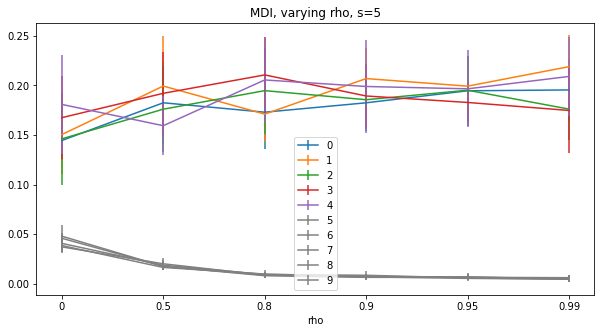

In [3]:
plt.figure(figsize=(10, 5))
for i in range(t):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i], yerr=mdi_stds[i], label=i)
for i in range(t, d):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i], yerr=mdi_stds[i], label=i, color="gray")
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("MDI, varying rho, s=5")
plt.show()

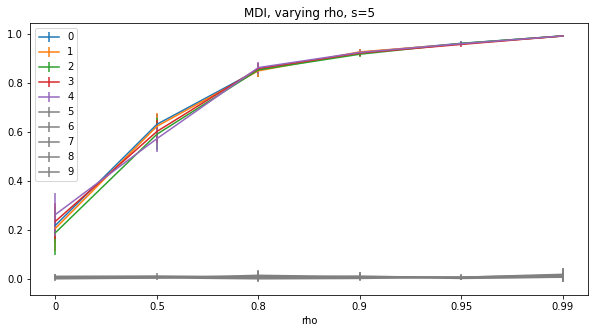

In [4]:
plt.figure(figsize=(10, 5))
for i in range(t):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i)
for i in range(t, d):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i, color="gray")
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("R2F, varying rho, s=5")
plt.show()

In [21]:
%%capture

n = 100
d = 10
s = 1
t = 5
rho_grid = [0, 0.5, 0.8, 0.9, 0.95, 0.99]
beta = 1
sigma = 0.1
runs = 10

mdi_means = []
mdi_stds = []
r2f_means = []
r2f_stds = []
# r2f_orig_means = []
# r2f_orig_stds = []
for rho in tqdm(rho_grid):
    Sigma = np.eye(d)
    for i in range(t):
        for j in range(i):
            Sigma[i, j] = rho
            Sigma[j, i] = rho
    mdi_results = []
    r2f_results = []
    # r2f_orig_results = []
    for r in range(runs):
        X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
        y = linear_model(X, sigma, s, beta)
        rf_model = RandomForestRegressor(max_features=0.33)
        rf_model.fit(X, y)
        mdi_results.append(rf_model.feature_importances_ / np.sum(rf_model.feature_importances_))
        tree_tester = TreeTester(rf_model)
        r2f_results.append(tree_tester.get_r_squared_sig_threshold(X, y, add_linear=False))
        # _, r2f_orig_result = tree_tester.get_feature_significance_and_ranking(X, y)
        # r2f_orig_results.append(r2f_orig_result)
    mdi_results = np.array(mdi_results)
    r2f_results = np.array(r2f_results)
    # r2f_orig_results = np.array(r2f_orig_results)
    mdi_means.append(np.mean(mdi_results, axis=0))
    mdi_stds.append(np.std(mdi_results, axis=0))
    r2f_means.append(np.mean(r2f_results, axis=0))
    r2f_stds.append(np.std(r2f_results, axis=0))
    # r2f_orig_means.append(np.mean(r2f_results, axis=0))
    # r2f_orig_stds.append(np.std(r2f_results, axis=0))
mdi_means = pd.DataFrame(mdi_means)
mdi_stds = pd.DataFrame(mdi_stds)
r2f_means = pd.DataFrame(r2f_means)
r2f_stds = pd.DataFrame(r2f_stds)
# r2f_orig_means = pd.DataFrame(r2f_means)
# r2f_orig_stds = pd.DataFrame(r2f_stds)

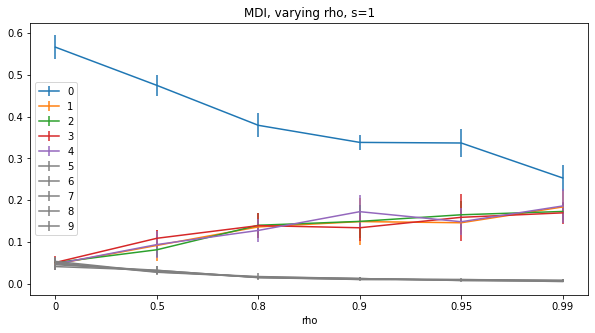

In [20]:
plt.figure(figsize=(10, 5))
for i in range(t):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i], yerr=mdi_stds[i], label=i)
for i in range(t, d):
    plt.errorbar(range(len(rho_grid)), mdi_means.iloc[:,i], yerr=mdi_stds[i], label=i, color="gray")
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("MDI, varying rho, s=1")
plt.show()

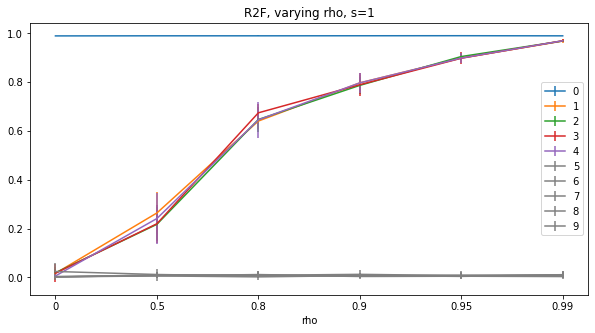

In [13]:
plt.figure(figsize=(10, 5))
for i in range(t):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i)
for i in range(t, d):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i, color="gray")
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("R2F, varying rho, s=1")
plt.show()

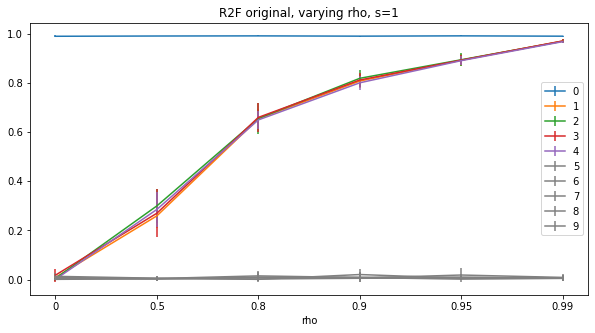

In [15]:
plt.figure(figsize=(10, 5))
for i in range(t):
    plt.errorbar(range(len(rho_grid)), r2f_orig_means.iloc[:,i], yerr=r2f_orig_stds[i], label=i)
for i in range(t, d):
    plt.errorbar(range(len(rho_grid)), r2f_orig_means.iloc[:,i], yerr=r2f_orig_stds[i], label=i, color="gray")
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("R2F original, varying rho, s=1")
plt.show()

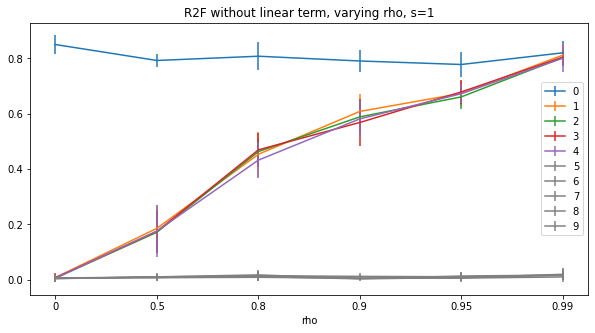

In [22]:
plt.figure(figsize=(10, 5))
for i in range(t):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i)
for i in range(t, d):
    plt.errorbar(range(len(rho_grid)), r2f_means.iloc[:,i], yerr=r2f_stds[i], label=i, color="gray")
plt.legend()
plt.xticks(ticks=range(len(rho_grid)), labels=rho_grid)
plt.xlabel("rho")
plt.title("R2F without linear term, varying rho, s=1")
plt.show()

# Temp

In [16]:
enhancer_results = pd.read_csv("results.csv")

In [17]:
enhancer_results

,sigma,sigma_name,rep,n_estimators,min_samples_leaf,max_features,model,fi,splitting_strategy,rocauc,...,r2_prauc,r2_pval_cor,time,split_seed,index,var,importance,r2_x,support,r2_y
0,0.1,0.1,0,100,5,0.33,RF,TreeSig,NaN,0.661111,...,0.480853,0.973256,0.884144,331,0,0,0.051310,0.002873,0.0,0.002873
1,0.1,0.1,0,100,5,0.33,RF,TreeSig,NaN,0.661111,...,0.480853,0.973256,0.884144,331,0,1,0.000000,0.643277,1.0,0.643277
2,0.1,0.1,0,100,5,0.33,RF,TreeSig,NaN,0.661111,...,0.480853,0.973256,0.884144,331,0,2,0.001753,0.005281,1.0,0.005281
3,0.1,0.1,0,100,5,0.33,RF,TreeSig,NaN,0.661111,...,0.480853,0.973256,0.884144,331,0,3,0.000123,0.011462,1.0,0.011462
4,0.1,0.1,0,100,5,0.33,RF,TreeSig,NaN,0.661111,...,0.480853,0.973256,0.884144,331,0,4,0.000000,0.584149,1.0,0.584149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15370,4.0,4.0,24,100,5,0.33,RF,Permutation,NaN,0.888889,...,NaN,NaN,0.947956,331,374,36,0.002537,NaN,NaN,NaN
15371,4.0,4.0,24,100,5,0.33,RF,Permutation,NaN,0.888889,...,NaN,NaN,0.947956,331,374,37,0.001613,NaN,NaN,NaN
15372,4.0,4.0,24,100,5,0.33,RF,Permutation,NaN,0.888889,...,NaN,NaN,0.947956,331,374,38,0.001148,NaN,NaN,NaN
15373,4.0,4.0,24,100,5,0.33,RF,Permutation,NaN,0.888889,...,NaN,NaN,0.947956,331,374,39,0.008942,NaN,NaN,NaN


In [8]:
r2f_means

,0,1,2,3,4,5,6,7,8,9
0,0.989693,0.016293,0.018713,0.016854,0.005495,0.023866,0.003014,0.000910,0.002533,0.001781
1,0.990090,0.263795,0.217265,0.219647,0.240991,0.011527,0.005991,0.009137,0.009377,0.005649
2,0.990038,0.640606,0.646883,0.674327,0.645565,0.005153,0.011319,0.009425,0.008229,0.001776
3,0.990279,0.797084,0.786881,0.789605,0.797143,0.007715,0.004550,0.003410,0.012193,0.006847
4,0.990492,0.898972,0.905057,0.898131,0.898851,0.003709,0.006798,0.004448,0.007145,0.008595
5,0.989959,0.968612,0.968932,0.969895,0.969672,0.010855,0.004286,0.003096,0.010039,0.009024


In [9]:
import statsmodels.api as sm

In [10]:
X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
y = linear_model(X, sigma, s, beta)
OLS_results = sm.OLS(y, X).fit(cov_type="HC0")

In [11]:
rf_model = RandomForestRegressor(max_features=0.33)
rf_model.fit(X, y)
tree_tester = TreeTester(rf_model)
tree_tester.get_r_squared_sig_threshold(X, y)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsm

array([0.98677796, 0.97075065, 0.96729734, 0.96414898, 0.96681471,
       0.00985322, 0.        , 0.        , 0.        , 0.        ])

In [26]:
OLS_results.rsquared

0.9906710228632398

In [46]:
p_values = np.zeros(d)
OLS_full = sm.OLS(y, X[:,0]).fit()
p_values[0] = OLS_full.f_pvalue
for i in range(1, d):
    OLS_restricted = OLS_full
    OLS_full = sm.OLS(y, X[:, np.arange(i+1)]).fit(cov_type="HC0")
    p_values[i] = OLS_full.compare_f_test(OLS_restricted)[1]

/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)
/Users/yanshuotan/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2169:

In [47]:
p_values

array([1.06529759e-08, 1.36904701e-08, 3.56131196e-09, 2.40096796e-19,
       3.26383207e-89, 9.93559410e-01, 5.96610470e-01, 2.47511865e-01,
       6.89876141e-01, 1.16475755e-01])

In [17]:
results = sm.OLS(y, X[:,0]).fit()

In [49]:
np.nonzero([False, False, False])[0]

array([], dtype=int64)